<a href="https://colab.research.google.com/github/fatmatosunytu/5/blob/main/first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install imbalanced-learn
!pip install seaborn


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from google.colab import files

In [7]:
df = pd.read_csv("water_potability.csv")

In [8]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB
None
                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085 

In [9]:
print(df.isnull().sum())
df.fillna(df.median(), inplace=True)

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


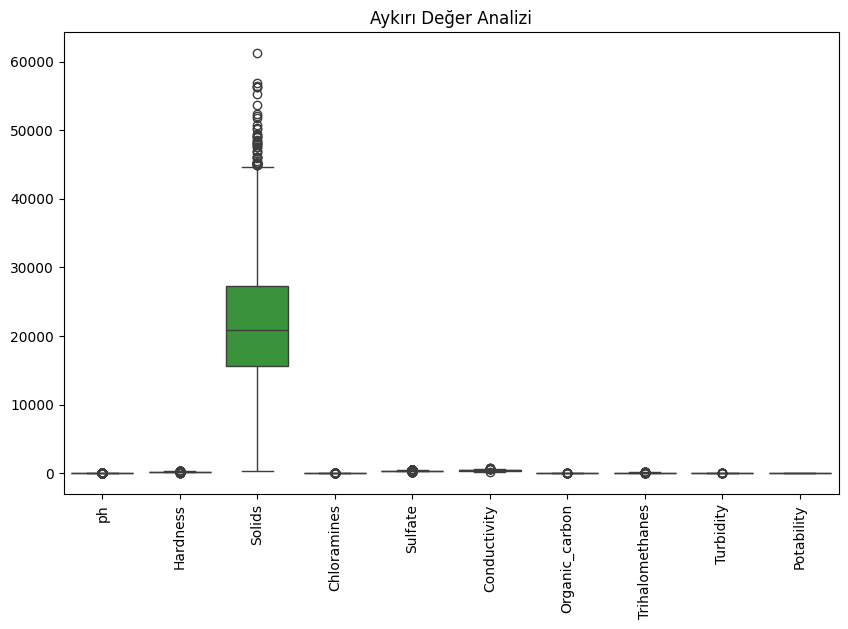

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df)
plt.title("Aykırı Değer Analizi")
plt.xticks(rotation=90)
plt.show()

In [11]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]), columns=df.columns[:-1])

In [12]:
X = df_scaled
y = df["Potability"]
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [13]:
print("SMOTE sonrası içilebilir ve içilemez su dağılımı:")
print(pd.Series(y_resampled).value_counts())

SMOTE sonrası içilebilir ve içilemez su dağılımı:
Potability
0    1998
1    1998
Name: count, dtype: int64


In [14]:
Q1 = df["Solids"].quantile(0.25)  # 1. Çeyrek
Q3 = df["Solids"].quantile(0.75)  # 3. Çeyrek
IQR = Q3 - Q1  # IQR Hesaplama

# Alt ve Üst Sınırları Belirleme
alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

# Aykırı Değerleri Filtreleme
df = df[(df["Solids"] >= alt_sinir) & (df["Solids"] <= ust_sinir)]


In [15]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # 1. Çeyrek (25%)
    Q3 = df[column].quantile(0.75)  # 3. Çeyrek (75%)
    IQR = Q3 - Q1  # IQR Hesaplama
    alt_sinir = Q1 - 1.5 * IQR  # Alt sınır
    ust_sinir = Q3 + 1.5 * IQR  # Üst sınır

    # Sadece belirlenen sınırlar içindeki değerleri tut
    df_cleaned = df[(df[column] >= alt_sinir) & (df[column] <= ust_sinir)]
    return df_cleaned

# "Solids" değişkeninden aykırı değerleri temizleyelim
df = remove_outliers_iqr(df, "Solids")


In [16]:
def winsorize_data(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    alt_sinir = Q1 - 1.5 * IQR
    ust_sinir = Q3 + 1.5 * IQR

    # Aykırı değerleri alt ve üst sınırlara çek
    df[column] = np.clip(df[column], alt_sinir, ust_sinir)
    return df

# "Solids" değişkenini Winsorizing yöntemiyle sınırlandıralım
df = winsorize_data(df, "Solids")


In [17]:
from scipy import stats

def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column]))
    df_cleaned = df[z_scores < threshold]  # Z-skoru 3’ten küçük olanları tut
    return df_cleaned

# "Solids" değişkeninden Z-Skoru yöntemiyle aykırı değerleri temizleyelim
df = remove_outliers_zscore(df, "Solids")


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


In [19]:
# Bağımsız değişkenler (X) ve bağımlı değişken (y)
X = df.drop(columns=["Potability"])
y = df["Potability"]

# StandardScaler ile veriyi ölçeklendirme
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# SMOTE ile sınıf dengesini sağlama
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Eğitim ve test setlerine ayırma (80% eğitim, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [20]:
# Random Forest Modeli
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Model Doğruluk Oranı: 0.74

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       379
           1       0.77      0.71      0.74       409

    accuracy                           0.74       788
   macro avg       0.74      0.74      0.74       788
weighted avg       0.74      0.74      0.74       788



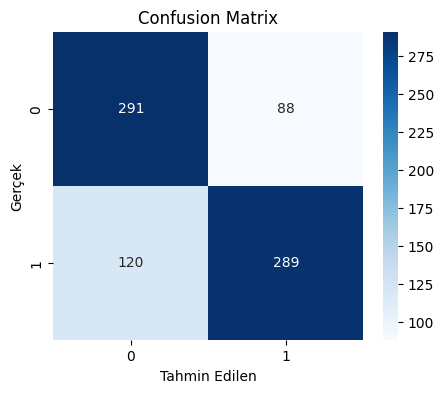

In [21]:
# Tahminler yapalım
y_pred = model.predict(X_test)

# Modelin doğruluğunu hesaplayalım
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Doğruluk Oranı: {accuracy:.2f}")

# Sınıflandırma raporu (Precision, Recall, F1-score)
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()


In [22]:
from sklearn.model_selection import GridSearchCV

# Random Forest için en iyi parametreleri belirleme
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("En iyi parametreler:", grid_search.best_params_)


En iyi parametreler: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


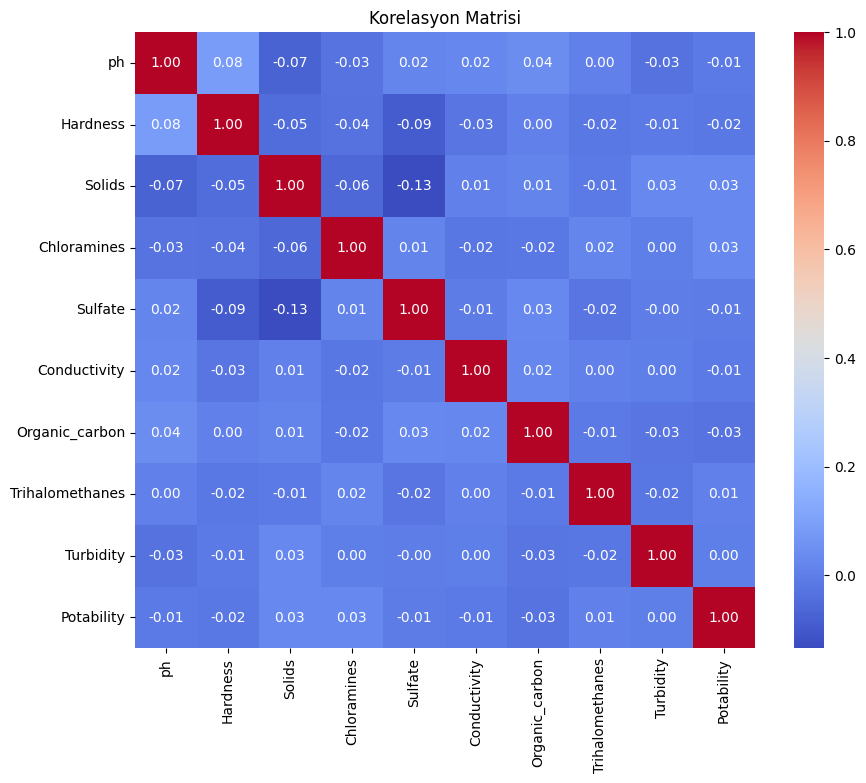

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()


In [24]:
# 0.85 üzeri korelasyonu olan değişkenleri bulma
correlation_matrix = df.corr()
high_corr_features = [column for column in correlation_matrix.columns if any(correlation_matrix[column] > 0.85)]
print("Çok yüksek korelasyonlu değişkenler:", high_corr_features)

# Bu değişkenleri veri setinden çıkarabiliriz
df.drop(columns=high_corr_features, inplace=True)


Çok yüksek korelasyonlu değişkenler: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']


In [26]:
from sklearn.feature_selection import VarianceThreshold



In [30]:
# Belirli bir varyans eşiğinin altındaki değişkenleri kaldır (örneğin 0.01)
var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(df)

low_variance_features = df.columns[var_thresh.get_support() == False]
print("Düşük varyanslı değişkenler:", low_variance_features)

# Veri setinden çıkar
df.drop(columns=low_variance_features, inplace=True)


Düşük varyanslı değişkenler: Index([], dtype='object')


In [29]:
from sklearn.feature_selection import VarianceThreshold

# Yalnızca sayısal sütunları seç
df_numeric = df.select_dtypes(include=["number"])

# Varyans eşiği belirleme ve uygulama
var_thresh = VarianceThreshold(threshold=0.01)
var_thresh.fit(df_numeric)  # Sadece sayısal sütunları kullan


VarianceThreshold(threshold=0.01)

In [33]:
# Yeni değişken ekleme
df["TDS"] = df["Solids"] + df["Sulfate"] + df["Conductivity"]

# pH değerini normalize etme (0-1 arasına çekme)
df["ph_norm"] = (df["ph"] - df["ph"].min()) / (df["ph"].max() - df["ph"].min())

# Sertlik sınıflandırması (Hardness)
df["Hardness_Cat"] = pd.cut(df["Hardness"], bins=[0, 100, 200, 500], labels=["Soft", "Medium", "Hard"])


In [35]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=["Potability"])  # Bağımsız değişkenler
y = df["Potability"]  # Bağımlı değişken




In [37]:
from sklearn.preprocessing import LabelEncoder

# Kategorik değişkenleri sayısal hale getir
label_encoder = LabelEncoder()

# "Hardness_Cat" sütunu varsa onu sayısal hale getir
if "Hardness_Cat" in df.columns:
    df["Hardness_Cat"] = label_encoder.fit_transform(df["Hardness_Cat"])

# Modelin eğitildiği X veri setinde sadece sayısal değişkenler olduğundan emin ol
X = df.select_dtypes(include=["number"]).drop(columns=["Potability"])  # Bağımsız değişkenler
y = df["Potability"]  # Bağımlı değişken (Hedef değişken)

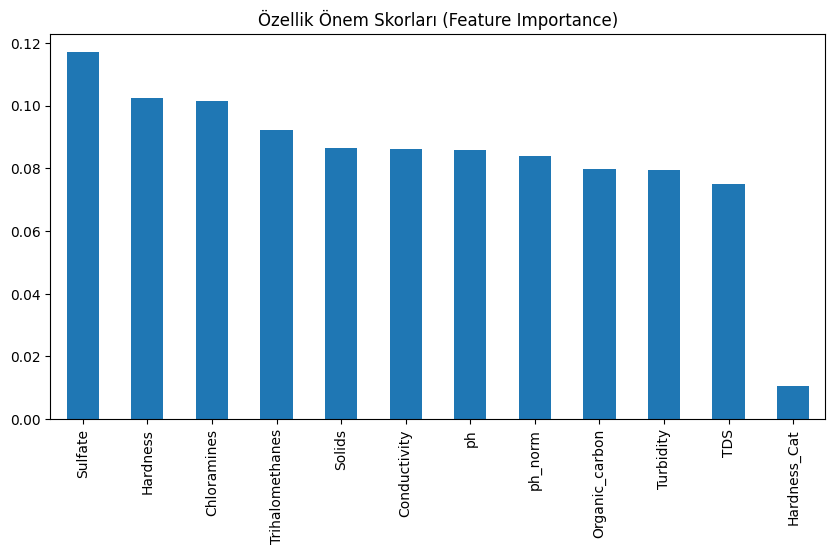

In [38]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=["Potability"])  # Bağımsız değişkenler
y = df["Potability"]  # Bağımlı değişken

# Random Forest Modeli
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Değişken önemini görselleştirme
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind="bar", figsize=(10, 5))
plt.title("Özellik Önem Skorları (Feature Importance)")
plt.show()


In [40]:
print("Eğitim veri setindeki sütunlar:", X_train.columns)
print("Test veri setindeki sütunlar:", X_test.columns)


Eğitim veri setindeki sütunlar: Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'],
      dtype='object')
Test veri setindeki sütunlar: Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity'],
      dtype='object')


In [42]:
# TDS değişkenini tekrar oluştur
df["TDS"] = df["Solids"] + df["Sulfate"] + df["Conductivity"]

# pH değerini normalize et
df["ph_norm"] = (df["ph"] - df["ph"].min()) / (df["ph"].max() - df["ph"].min())

# Hardness sınıflandırmasını tekrar yap
df["Hardness_Cat"] = pd.cut(df["Hardness"], bins=[0, 100, 200, 500], labels=["Soft", "Medium", "Hard"])

# Kategorik değişkenleri sayısala çevir
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Hardness_Cat"] = label_encoder.fit_transform(df["Hardness_Cat"])


In [45]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [47]:

# Test verisindeki sütunları eğitim verisine uygun hale getir
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # Eksik sütunları 0 ile doldur

# Sütunları aynı sıraya getir
X_test = X_test[X_train.columns]

In [51]:
# Test verisinin sütunlarını eğitim verisine göre sıralayalım
X_test = X_test[X_train.columns]


In [53]:
print("Eğitim veri seti sütunları:", list(X_train.columns))
print("Test veri seti sütunları:", list(X_test.columns))


Eğitim veri seti sütunları: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
Test veri seti sütunları: ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']


In [57]:
# Eksik sütunları test veri setine ekleyelim
missing_cols = {"Hardness_Cat": 0, "TDS": 0, "ph_norm": 0}  # Varsayılan değerlerle ekleme
for col, value in missing_cols.items():
    if col not in X_test.columns:
        X_test[col] = value  # Eksik olan sütunları 0 ile doldur

# Sütunları tekrar sıraya sokalım
X_test = X_test[X_train.columns]

In [59]:
# TDS değişkenini hesapla
X_test["TDS"] = X_test["Solids"] + X_test["Sulfate"] + X_test["Conductivity"]

# pH değerini normalize et
X_test["ph_norm"] = (X_test["ph"] - X_test["ph"].min()) / (X_test["ph"].max() - X_test["ph"].min())

# Hardness sınıflandırmasını ekle
import pandas as pd
X_test["Hardness_Cat"] = pd.cut(X_test["Hardness"], bins=[0, 100, 200, 500], labels=["Soft", "Medium", "Hard"])

# Hardness_Cat değişkenini sayısallaştır
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
X_test["Hardness_Cat"] = label_encoder.fit_transform(X_test["Hardness_Cat"])

# Sütunları tekrar sıraya sok
X_test = X_test[X_train.columns]


<ipython-input-59-90fdfc0fe8a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["TDS"] = X_test["Solids"] + X_test["Sulfate"] + X_test["Conductivity"]
<ipython-input-59-90fdfc0fe8a0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["ph_norm"] = (X_test["ph"] - X_test["ph"].min()) / (X_test["ph"].max() - X_test["ph"].min())


In [61]:
# Add missing features to X_test and ensure they're in the same order as X_train
X_test["TDS"] = X_test["Solids"] + X_test["Sulfate"] + X_test["Conductivity"]
X_test["ph_norm"] = (X_test["ph"] - X_test["ph"].min()) / (X_test["ph"].max() - X_test["ph"].min())
X_test["Hardness_Cat"] = pd.cut(X_test["Hardness"], bins=[0, 100, 200, 500], labels=["Soft", "Medium", "Hard"])

# Convert "Hardness_Cat" to numerical using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
X_test["Hardness_Cat"] = label_encoder.fit_transform(X_test["Hardness_Cat"])

# Ensure X_test has the same columns and order as X_train
X_test = X_test[X_train.columns]

<ipython-input-61-3c3f33fccc81>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["TDS"] = X_test["Solids"] + X_test["Sulfate"] + X_test["Conductivity"]
<ipython-input-61-3c3f33fccc81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["ph_norm"] = (X_test["ph"] - X_test["ph"].min()) / (X_test["ph"].max() - X_test["ph"].min())


In [64]:
# Test veri setini tam kopya olarak oluştur (Sorunu önler)
X_test = X_test.copy()

# TDS değişkenini hesapla
X_test.loc[:, "TDS"] = X_test["Solids"] + X_test["Sulfate"] + X_test["Conductivity"]

# pH değerini normalize et
X_test.loc[:, "ph_norm"] = (X_test["ph"] - X_test["ph"].min()) / (X_test["ph"].max() - X_test["ph"].min())

# Hardness sınıflandırmasını ekle
X_test.loc[:, "Hardness_Cat"] = pd.cut(X_test["Hardness"], bins=[0, 100, 200, 500], labels=["Soft", "Medium", "Hard"])

# Hardness_Cat değişkenini sayısal hale getir
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
X_test.loc[:, "Hardness_Cat"] = label_encoder.fit_transform(X_test["Hardness_Cat"])

# Sütunları tekrar sıraya sok
X_test = X_test[X_train.columns]


<ipython-input-64-5da2b5f946f0>:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 1 0
 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 1 0
 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1
 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1
 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0
 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0
 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1
 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1
 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1
 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1
 0 0 0 1 0 1 1 0 0 0 

In [67]:
# Eksik sütunları ekleyelim
X_test = X_test.copy()  # Kopya oluştur, hata riskini azalt

X_test["TDS"] = X_test["Solids"] + X_test["Sulfate"] + X_test["Conductivity"]
X_test["ph_norm"] = (X_test["ph"] - X_test["ph"].min()) / (X_test["ph"].max() - X_test["ph"].min())

# Hardness sınıflandırmasını ekle
X_test["Hardness_Cat"] = pd.cut(X_test["Hardness"], bins=[0, 100, 200, 500], labels=["Soft", "Medium", "Hard"])

# Kategorik değişkeni sayısal hale getir
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
X_test["Hardness_Cat"] = label_encoder.fit_transform(X_test["Hardness_Cat"])

# **Sütunların Sırasını Düzenle** (Eğitim seti ile aynı hale getir)
X_test = X_test[X_train.columns]

In [70]:
# Test verisine eksik olan sütunları ekle
X_test["TDS"] = X_test["Solids"] + X_test["Sulfate"] + X_test["Conductivity"]
X_test["ph_norm"] = (X_test["ph"] - X_test["ph"].min()) / (X_test["ph"].max() - X_test["ph"].min())
X_test["Hardness_Cat"] = pd.cut(X_test["Hardness"], bins=[0, 100, 200, 500], labels=["Soft", "Medium", "Hard"])

# Kategorik değişkeni sayısallaştır
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
X_test["Hardness_Cat"] = label_encoder.fit_transform(X_test["Hardness_Cat"])


In [71]:
# Test verisinin sütunlarını eğitim verisinin sırasına göre ayarla
X_test = X_test[X_train.columns]


In [72]:
# Tahmin yap
y_pred = rf_model.predict(X_test)

# Model doğruluk oranı
accuracy = accuracy_score(y_test, y_pred)
print(f"📌 Model Doğruluk Oranı: {accuracy:.2f}")

# Sınıflandırma raporu ve Confusion Matrix
print("\n📌 Sınıflandırma Raporu:\n", classification_report(y_test, y_pred))

# Confusion Matrix Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Hardness_Cat
- TDS
- ph_norm


In [73]:
rf_model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)